In this notebook, we use the MICE method (https://www.statsmodels.org/devel/generated/statsmodels.imputation.mice.MICE.html) to impute missing data in the Enefit training set covering Sept 1, 2021 to May 31, 2023.

Citation:
Kristjan Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). 
Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers

# 1. Missing data

First, we check how much of the data is missing. Below, we see that only the 'target' and '48h_shift' column have missing data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

df = pd.read_csv('/kaggle/input/trainingdata/trainingData.csv') 
df['datetime'] = pd.to_datetime(df['datetime'])
df=df[['county', 'is_business', 'is_consumption', 'product_type', 'target', 'datetime']]

# Data containes 6 columns; 'county', 'is_business', 'is_consumption', and 'product_type', which are categorical, and each determine a time series
# 'target' is the data we want to predict
# 'datetime' is the date that we need the forecast for



In [2]:
df.head()

,county,is_business,is_consumption,product_type,target,datetime
0,0,0,0,1,0.713,2021-09-01
1,0,0,1,1,96.590,2021-09-01
2,0,0,0,2,0.000,2021-09-01
3,0,0,1,2,17.314,2021-09-01
4,0,0,0,3,2.904,2021-09-01


As seen in the EDA notebook EnefitEDA, the dataframe contains 132 separate timeseries, each of them described by a tuple ('county', 'is_business', 'is_consumption', 'product_type'). We call such a tuple (county_value, is_business_value, is_consumption_value, product_type) the **signature** of the time series.

While the dataframe has no NaN values, 20 out of the 132 time series are missing readings at some time slots. We will impute this missing data using the Multivariate Imputation by Chained Equations (MICE) method using the scikit-learn IterativeInputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html 

In order to use MICE, we will choose some full series (with no missing data) which are highly correlated with the series whose data we try to inpute. Indeed, we can easily find such series, especially among those with similar signatures.

In the figure below, we see the correlation values between timeseries with signatures (c, 0, 0, 1) and (c, 0, 1, 1), where c ranges among county values. 
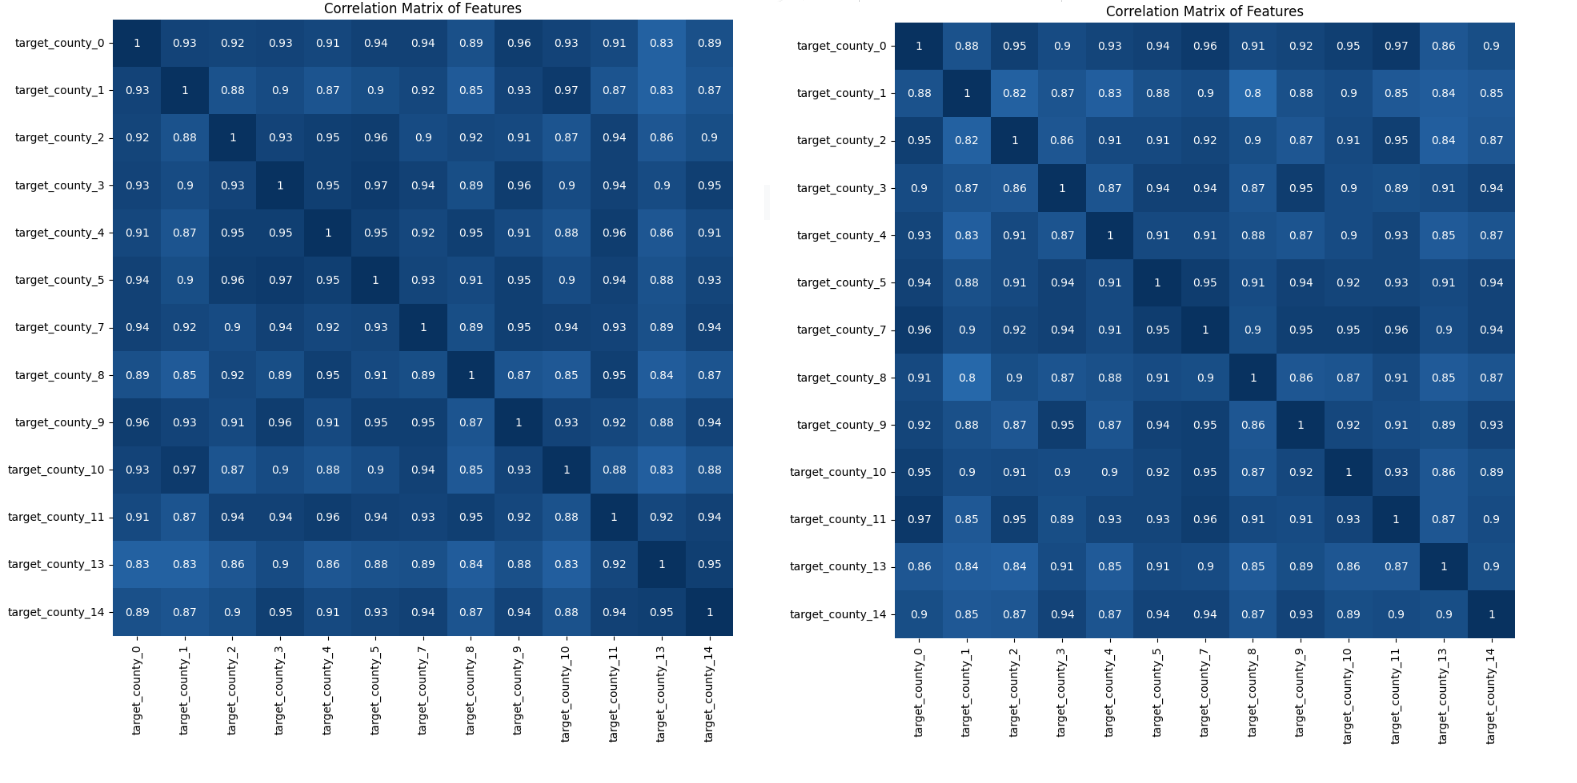


We combine all the timeseries in one dataframe, whose columns correspond to each timeseries.

In [3]:
from enefitutilsimputation import *

series =  SignedTimeSeries(df)
data = series.data
data.head()

2024-02-16 20:40:57.800964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 20:40:57.801102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 20:40:57.970506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,target_0_0_0_1,target_0_0_0_2,target_0_0_0_3,target_0_0_1_1,target_0_0_1_2,target_0_0_1_3,target_0_1_0_0,target_0_1_0_1,target_0_1_0_2,target_0_1_0_3,...,target_15_0_0_1,target_15_0_0_3,target_15_0_1_1,target_15_0_1_3,target_15_1_0_0,target_15_1_0_1,target_15_1_0_3,target_15_1_1_0,target_15_1_1_1,target_15_1_1_3
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.713,0.0,2.904,96.590,17.314,656.859,0.0,0.0,NaN,0.315,...,0.0,0.0,5.524,59.366,NaN,0.1,0.0,NaN,17.703,289.159
2021-09-01 01:00:00,1.132,0.0,0.983,77.691,15.872,595.498,0.0,0.0,NaN,0.353,...,0.0,0.0,4.632,56.357,NaN,0.1,0.0,NaN,20.416,280.657
2021-09-01 02:00:00,0.490,0.0,0.457,91.594,16.510,598.450,0.0,0.0,NaN,0.338,...,0.0,0.0,5.461,51.038,NaN,0.1,0.0,NaN,27.440,295.537
2021-09-01 03:00:00,0.496,0.0,0.460,87.955,14.271,622.824,0.0,0.0,NaN,0.303,...,0.0,0.0,4.617,48.482,NaN,0.0,0.0,NaN,19.050,287.724
2021-09-01 04:00:00,0.149,0.0,0.385,88.184,18.225,607.308,0.0,0.0,NaN,0.424,...,0.0,0.0,4.578,57.115,NaN,0.1,0.0,NaN,21.228,286.074


One of the series with missing data is the series with signature (2, 0, 0, 1). We illustrate our imputation method using this series:

In [4]:
column = 'target_2_0_0_1'
subframe_2001 = data[[column]]
print(" Signature (2, 0, 0, 1) has ",  data[column].isna().sum(), 'missing values out of', data.shape[0])

 Signature (2, 0, 0, 1) has  720 missing values out of 15312


# 2. Imputing data



Now we check which columns need to be imputed, and how many values. We will start from the ones with the fewest values to impute, and move up to series that need more imputations. The one exception we will do is for series with signature (0, 1, 0, 2) and (0, 1, 1, 2), which only have non-full series with similar signatures, and will need to be filled using higher-correlation series.

In [5]:
imputed_series = ImputedTimeSeries(series)
# The number of missing values to impute is as follows
print(imputed_series.nan_signatures())

{'target_0_1_0_2': 720, 'target_0_1_1_2': 720, 'target_2_0_0_1': 720, 'target_2_0_1_1': 720, 'target_2_1_0_1': 2928, 'target_2_1_1_1': 2928, 'target_4_1_0_1': 2928, 'target_4_1_1_1': 2928, 'target_5_1_0_0': 744, 'target_5_1_1_0': 744, 'target_11_0_0_2': 1200, 'target_11_0_1_2': 1200, 'target_11_1_0_0': 3672, 'target_11_1_0_2': 3312, 'target_11_1_1_0': 3672, 'target_11_1_1_2': 3312, 'target_13_1_0_1': 720, 'target_13_1_1_1': 720, 'target_15_1_0_0': 2184, 'target_15_1_1_0': 2184}


We will impute the series in the following order: 

First, signatures (2, 0, 0, 1), (2, 0, 1, 1), (13, 1, 0, 1), (13, 1, 1, 1), 

then 'target_5_1_0_0', 'target_5_1_1_0',

then 'target_11_0_0_2', 'target_11_0_1_2', 

then 'target_15_1_0_0',  'target_15_1_1_0',

then 'target_2_1_0_1', 'target_2_1_1_1', 'target_4_1_0_1', 'target_4_1_1_1',

then 'target_0_1_0_2', 'target_0_1_1_2',

then 'target_11_1_0_2', 'target_11_1_1_2',

and finally 'target_11_1_0_0', 'target_11_1_1_0'

### 2. 1. Example : Series (2, 0, 0, 1)

We start with signature (2, 0, 0, 1). We can either impute using the series (c, 0, 0, 1), whose correlations are shown in the left corre;ation matrix in the image at the beginning of the notebook, or we can use all the full series that are correlated with it with correlation coefficient > 0.9.  We sample 100 such imputations on a 30-day continuous time period using both methods below:

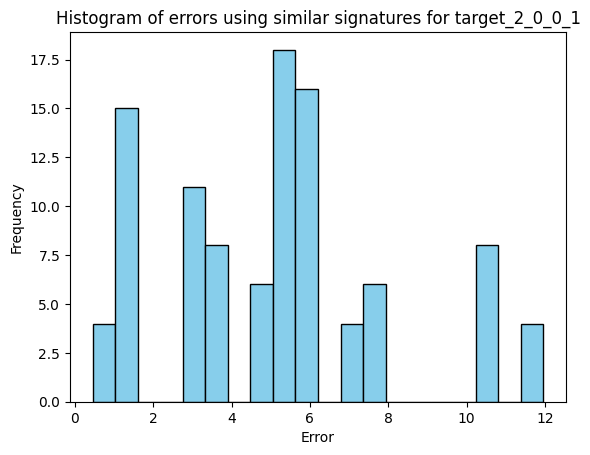

In [6]:
# Imputing using similar signatures (c, 0, 0, 1)

# this runs ~ 5 minutes
column = 'target_2_0_0_1'
errors_similar = []
sim_sers=[]
for i in range(100):   
    err_sim, num_sers_sim = imputed_series.calculate_error(column)
    errors_similar.append(err_sim)
    sim_sers.append(num_sers_sim)
    
plt.hist(errors_similar, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of errors using similar signatures for {column}')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

print("Number of series used for imputation is ", set(sim_sers))

In [ ]:
# Imputing using series with high correlations
# this runs ~ 5 minutes
column = 'target_2_0_0_1'
errors_high_corr = []
high_sers=[]
for i in range(100):   
    err_high, num_sers_high = imputed_series.calculate_error(column)
    errors_high_corr.append(err_high)
    sim_sers.append(num_sers_high)
    
plt.hist(errors_high_corr, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of errors using series with high correlations for {column}')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

print("Number of series used for imputation is ", set(high_sers))

Since the error is smaller using the highly correlated series, choose the second option. Below, we show how such an imputation looks like:

In [ ]:
imputed_series.calculate_error(column, all_corr=True, visualize = True)

We keep doing this for the first row of series we specified earlier, i.e. signatures (2, 0, 0, 1), (2, 0, 1, 1), (13, 1, 0, 1), (13, 1, 1, 1), (0, 1, 0, 2) and (0, 1, 1, 2). 

In [ ]:
imputed_series.impute('target_2_0_0_1', all_corr = True)
imputed_series.calculate_error('target_2_0_1_1', all_corr = True, visualize = True)
imputed_series.impute('target_2_0_1_1')
imputed_series.calculate_error('target_13_1_0_1', visualize = True)
imputed_series.impute('target_13_1_0_1')
imputed_series.calculate_error('target_13_1_1_1', visualize = True)
imputed_series.impute('target_13_1_1_1')
#imputed_series.calculate_error('target_0_1_0_2', visualize = True)
#imputed_series.impute('target_0_1_0_2')
#imputed_series.calculate_error('target_0_1_1_2', all_corr = True, visualize = True)
#imputed_series.impute('target_0_1_1_2', all_corr = True)

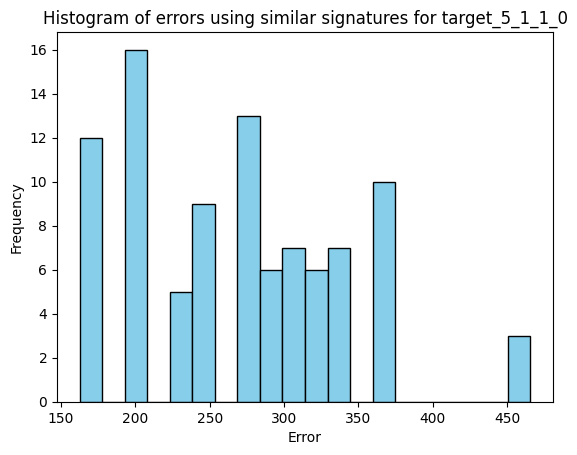

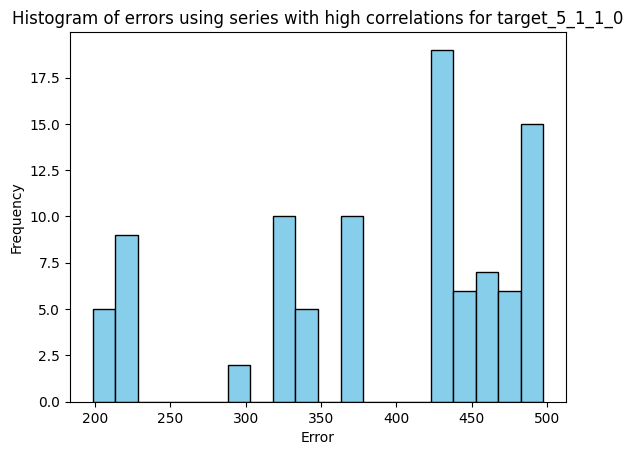

In [12]:
# Imputing using similar signatures 
column = 'target_5_1_1_0'
errors_similar = []
for i in range(100):   
    errors_similar.append(imputed_series.calculate_error(column))
    
plt.hist(errors_similar, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of errors using similar signatures for {column}')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Imputing using series with high correlations
errors_high_corr = []
for i in range(100):   
    errors_high_corr.append(imputed_series.calculate_error(column, all_corr=True))
    
plt.hist(errors_high_corr, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of errors using series with high correlations for {column}')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

Error for similar signatures is  465.74646
Error for all high correlations is  332.2885


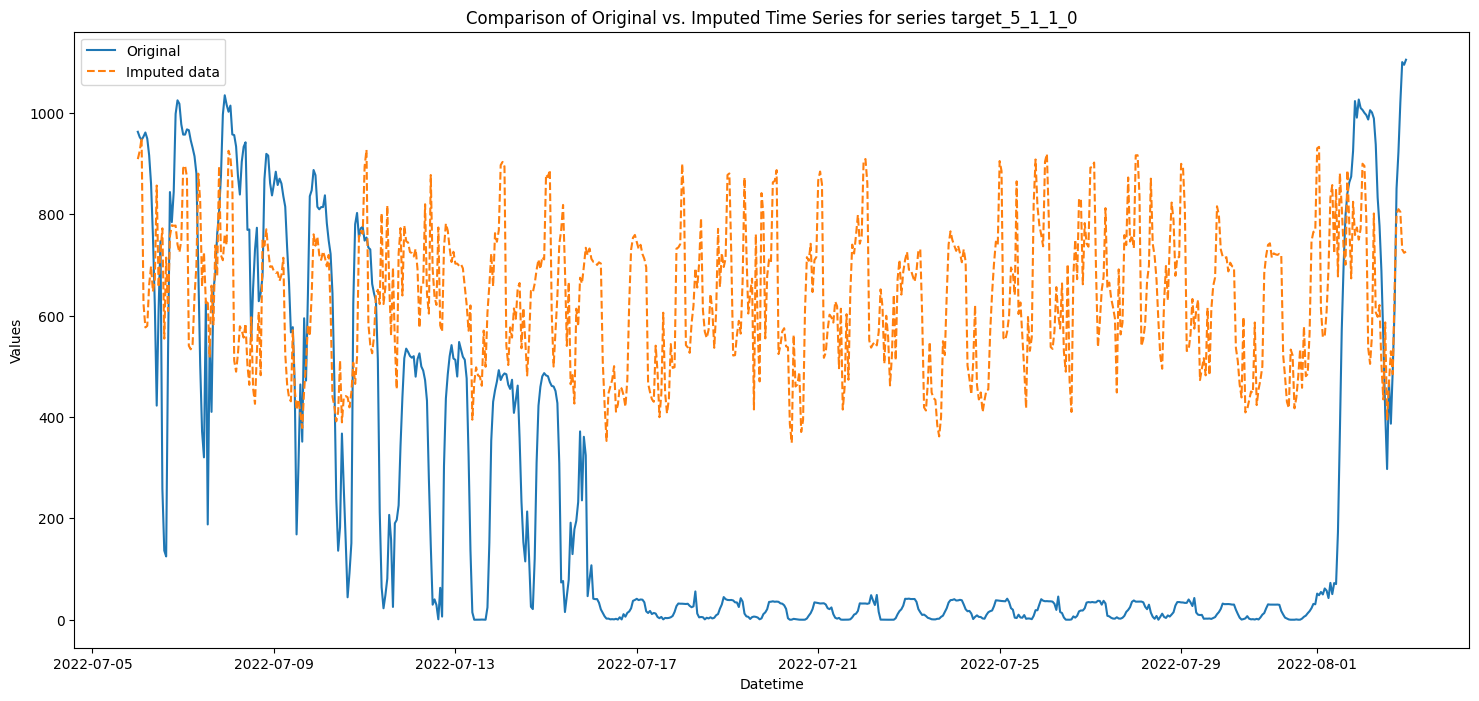

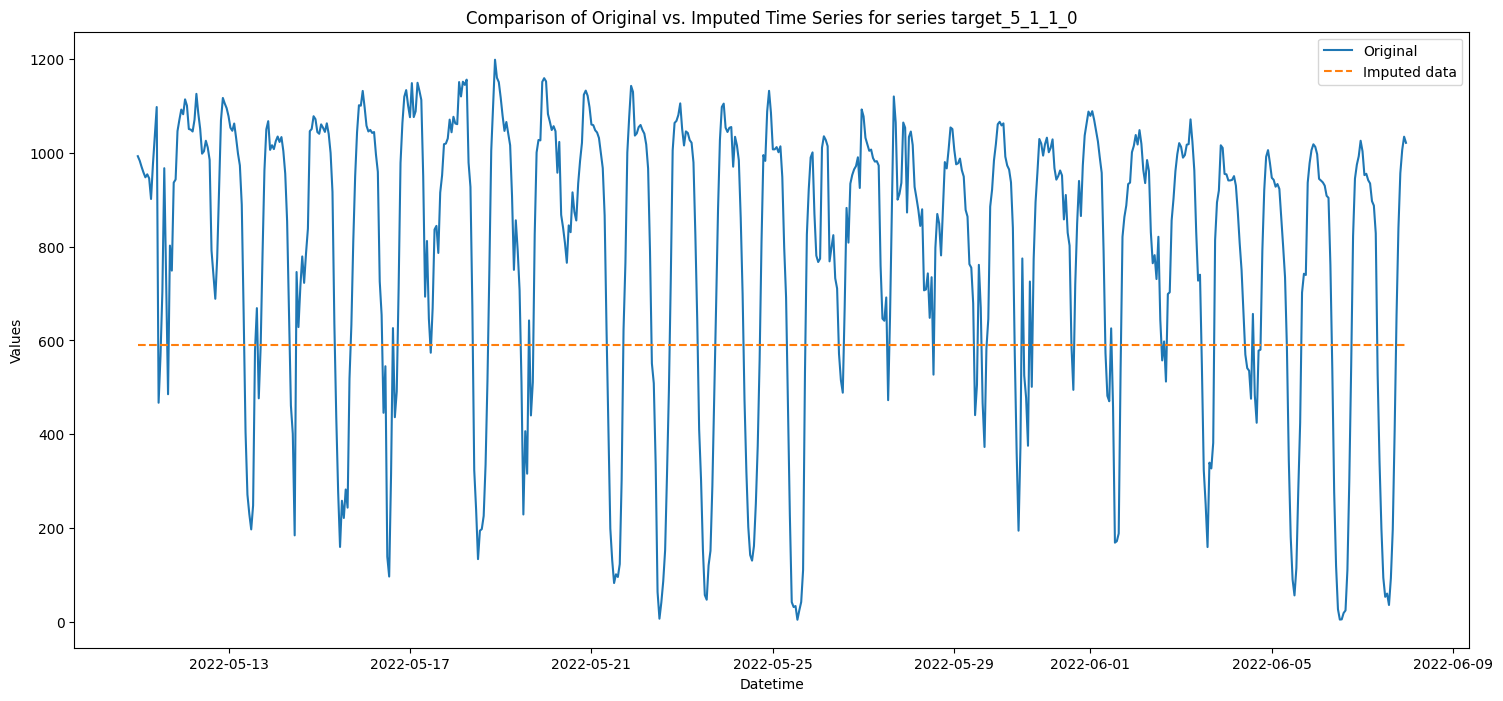

In [13]:
print("Error for similar signatures is ", imputed_series.calculate_error(column, visualize = True))
print("Error for all high correlations is ", imputed_series.calculate_error(column, all_corr = True, visualize = True))


In [ ]:
imputed_series.impute('target_5_1_0_0')
imputed_series.calculate_error('target_5_1_0_0', visualize = True)




imputed_series.impute('target_2_0_1_1')
imputed_series.calculate_error('target_13_1_0_1', visualize = True)
imputed_series.impute('target_13_1_0_1')
imputed_series.calculate_error('target_13_1_1_1', visualize = True)
imputed_series.impute('target_13_1_1_1')
#imputed_series.calculate_error('target_0_1_0_2', visualize = True)
#imputed_series.impute('target_0_1_0_2')
#imputed_series.calculate_error('target_0_1_1_2', all_corr = True, visualize = True)
#imputed_series.impute('target_0_1_1_2', all_corr = True)